In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from keras.applications import EfficientNetB0
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import layers
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
from sklearn.metrics import f1_score,confusion_matrix ,classification_report
from keras.callbacks import CSVLogger
import gradio as gr
from gradio.components import Textbox


In [8]:
path = 'ds/test'
labels=os.listdir(path)

data = pd.DataFrame({
    'Disease': labels+['total'],
    'count': np.zeros(11,dtype=int),
})

for folder in os.listdir(path):
    path1=os.path.join(path,folder)
    count = len(os.listdir(path1))
    
    index = data.index[data['Disease'] == folder]
    if folder in data['Disease'].values:
      index = data.index[data['Disease'] == folder][0]
      data.at[index, 'count'] = count

data.at[10,'count'] = sum(data['count'])
data


Disease  count
0                         Bacterial_spot    639
1                           Early_blight    300
2                                healthy    478
3                            Late_blight    573
4                              Leaf_Mold    286
5                           mosaic_virus    112
6                     Septoria_leaf_spot    532
7   Spider_mites Two-spotted_spider_mite    503
8                            Target_Spot    422
9                 Yellow_Leaf_Curl_Virus   1608
10                                 total   5453

In [15]:
TRAIN_PATH=r'ds/train'
X=[]
labels=[]
# add the first image for each category for plotting
for folder in os.listdir(TRAIN_PATH):
  path= os.path.join(TRAIN_PATH,folder)
  img= cv2.imread(os.path.join(path,os.listdir(path)[0]))
  img= cv2.resize(img, (200,200))
  img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  X.append(img)
  labels.append(folder)

In [16]:
X=np.array(X) # check sizes
X.shape


(10, 200, 200, 3)

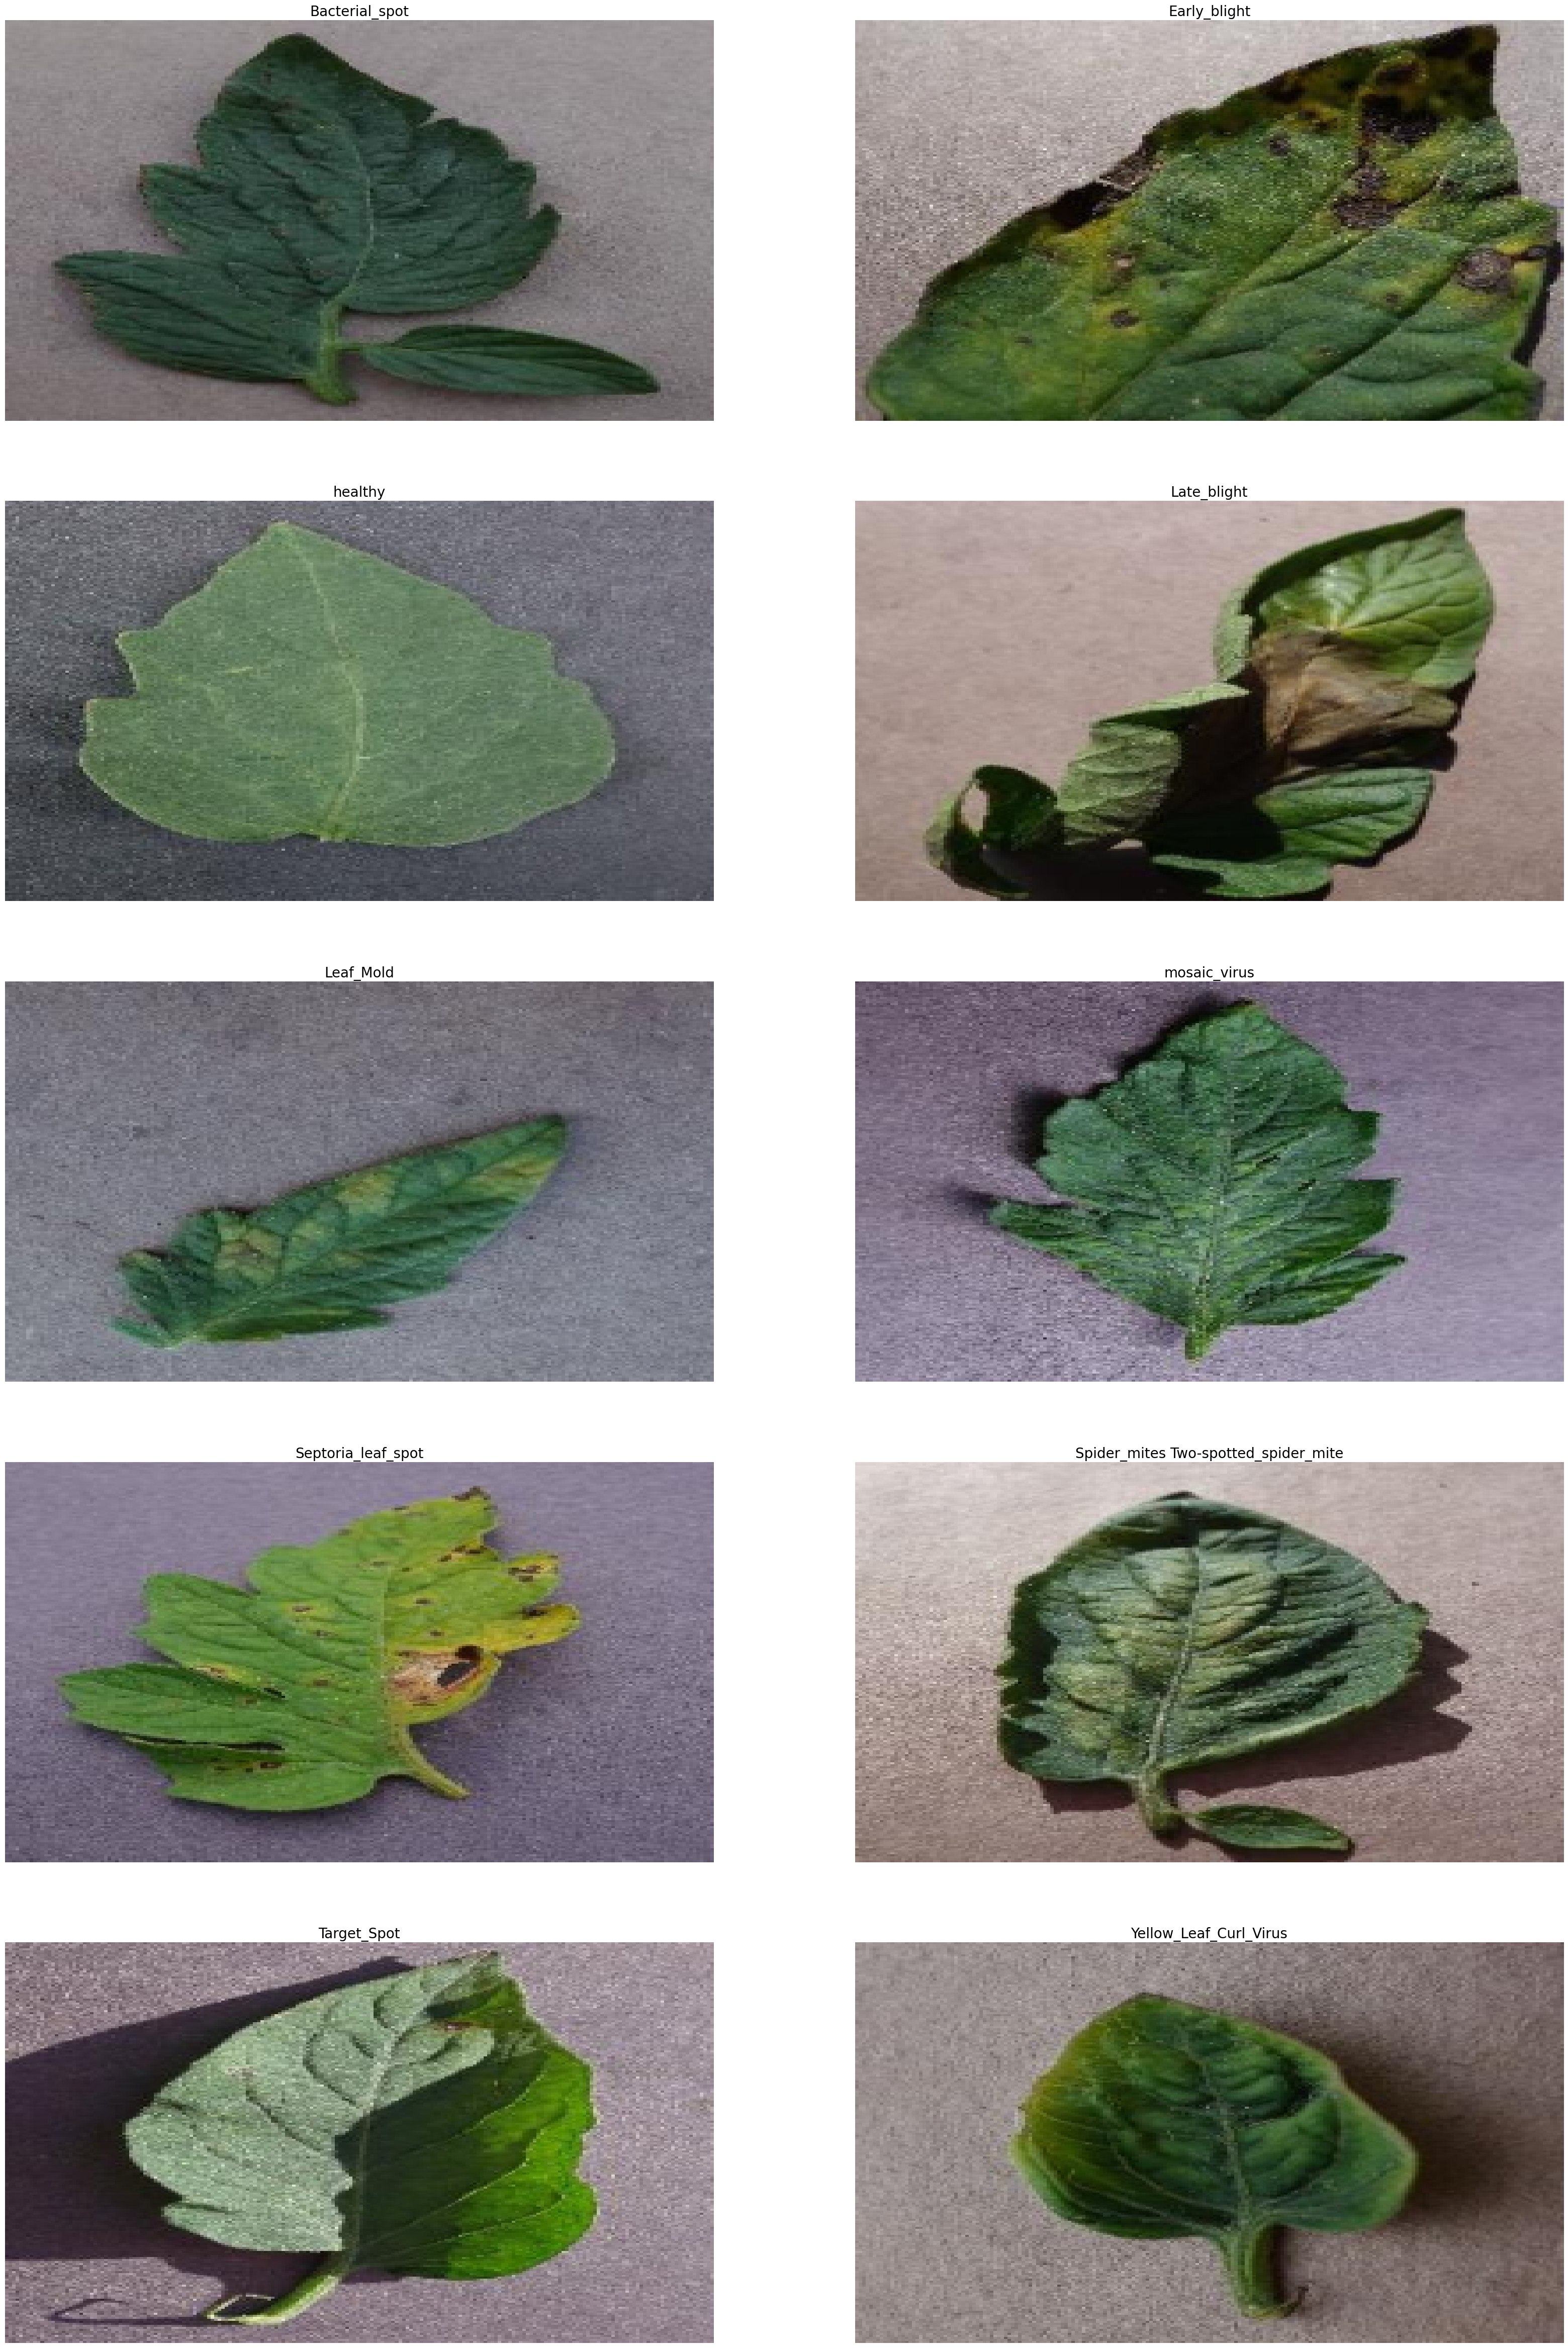

In [17]:
#plot an image of each fruit in each category


f, ax= plt.subplots(5,2, figsize=(40,60))
for i, img in enumerate(X):
  ax[i // 2][i % 2].imshow(img,aspect='auto')
  ax[i // 2][i % 2].set_title(labels[i],size=20)
  ax[i // 2][i % 2].axis('off')


SPLIT TO TRAIN/TEST

In [2]:
 # DS PATH : D:\UNI\4th year\SENIOR PROJECT\ABBAS_STUDY/ds

# Create data generators for train and test
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values to 0, 1
    validation_split=0.1 # 10% for validation
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
path= r'D:\UNI\4th year\SENIOR PROJECT\ABBAS_STUDY/ds'

# Load and preprocess the training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(path, 'train'),
    target_size=(224, 224),  # image size of 224 for VGG16
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# validation data
validation_generator = train_datagen.flow_from_directory(
    os.path.join(path, 'train'),
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  
)

#testing data
test_generator = test_datagen.flow_from_directory(
    os.path.join(path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 11441 images belonging to 10 classes.
Found 1266 images belonging to 10 classes.
Found 5453 images belonging to 10 classes.


In [6]:
efnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # pretrained model

# freeze learnable layers
for layer in efnet.layers:
    layer.trainable = False

In [7]:
efnet.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_2

In [8]:

model= Sequential()
model.add(efnet) # add the predefined densenet architecture 
model.add(Flatten())
model.add(Dense(256, activation='relu')) # relu as activation function
model.add(layers.BatchNormalization()) #no hurt to try 
model.add(Dropout(0.2)) # for regularization and avoiding overfitting
model.add(Dense(10, activation='softmax', name='Disease')) # outputs 10 classes


#compile
model.compile(optimizer=Adam(learning_rate=0.0001), # Adam is the gradient decent alg , it uses SGD 'stochastic gradient descent'
              loss='categorical_crossentropy', # the loss function used for finding error ,  
              metrics=['acc'])

csv_logger = CSVLogger('training.log', separator=',', append=False) # to save the model metrics in a log file 

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[csv_logger]
)

Epoch 1/20
358/358 [==============================] - 27s 62ms/step - loss: 1.0576 - acc: 0.6600 - val_loss: 0.5287 - val_acc: 0.8507
Epoch 2/20
358/358 [==============================] - 20s 57ms/step - loss: 0.5112 - acc: 0.8366 - val_loss: 0.3401 - val_acc: 0.8934
Epoch 3/20
358/358 [==============================] - 20s 57ms/step - loss: 0.3907 - acc: 0.8740 - val_loss: 0.2698 - val_acc: 0.9147
Epoch 4/20
358/358 [==============================] - 21s 58ms/step - loss: 0.3233 - acc: 0.8948 - val_loss: 0.2507 - val_acc: 0.9139
Epoch 5/20
358/358 [==============================] - 21s 57ms/step - loss: 0.2723 - acc: 0.9136 - val_loss: 0.2032 - val_acc: 0.9313
Epoch 6/20
358/358 [==============================] - 21s 58ms/step - loss: 0.2422 - acc: 0.9212 - val_loss: 0.1922 - val_acc: 0.9384
Epoch 7/20
358/358 [==============================] - 20s 56ms/step - loss: 0.2133 - acc: 0.9345 - val_loss: 0.1761 - val_acc: 0.9423
Epoch 8/20
358/358 [==============================] - 20s 56ms

In [ ]:
model.save('model_effnet.h5') # save the trained model to a file so we dont have to retrain after closing the project

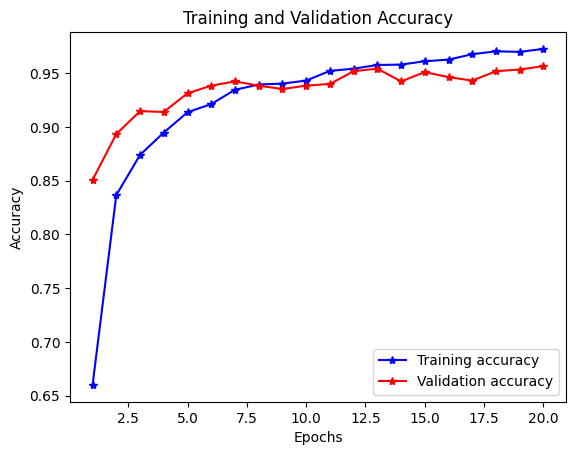

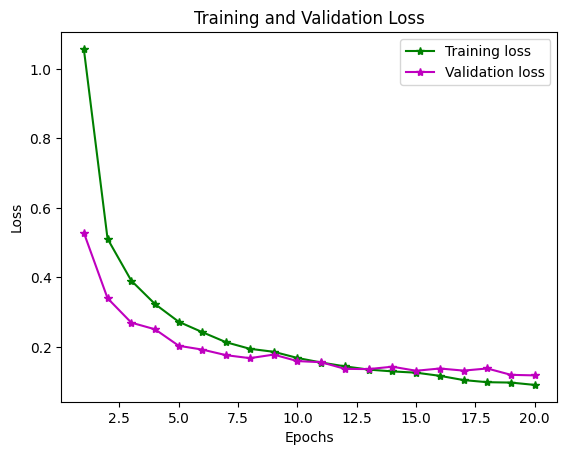

In [12]:
history = pd.read_csv('training-efficient_net.log.txt') # the model metrics history as a data frame 

train_acc = history['acc']
train_loss = history['loss']
val_acc = history['val_acc']  
val_loss = history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()
# Plot Training and Validation Loss on the same plot
plt.plot(epochs, train_loss, 'g*-', label='Training loss')
plt.plot(epochs, val_loss, 'm*-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [9]:
model= load_model('model_effnet.h5') # the trained model

In [10]:
predictions = model.predict(test_generator) # run the model on the test set
np.save('effnet_predictions.npy',predictions)# save the predictions array to a file for faster usage


171/171 [==============================] - 357s 2s/step


# LOADED MODEL

In [6]:
model= load_model('model_effnet.h5') # the trained model
predictions = np.load('effnet_predictions.npy') # the predictions 
history = pd.read_csv('training-efficient_net.log.txt') # the model metrics history as a data frame

In [ ]:
loss,acc = model.evaluate(test_generator)
print(f'Test accuracy: {acc}')
print(f'Test loss: {loss}')

# TESTING


In [4]:
# a function that calclates the error and the test accuracy and plot the confusion matrix and classification report
def predictor(test_gen,preds):  # takes the test set and the predictions array as arguments  
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys()) # extract the labels 
    class_count=len(classes)
    errors=0
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # if a misclassification has occurred                                           
            errors=errors + 1 #count error
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100 # calculate the accuracy
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%') # print the test accuracy
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100 # f1 score
    cm = confusion_matrix(ytrue, ypred) # confusion matrix
    # plot the confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return acc,f1score,cm,clr 

there were 216 errors in 5453 tests for an accuracy of  96.04%


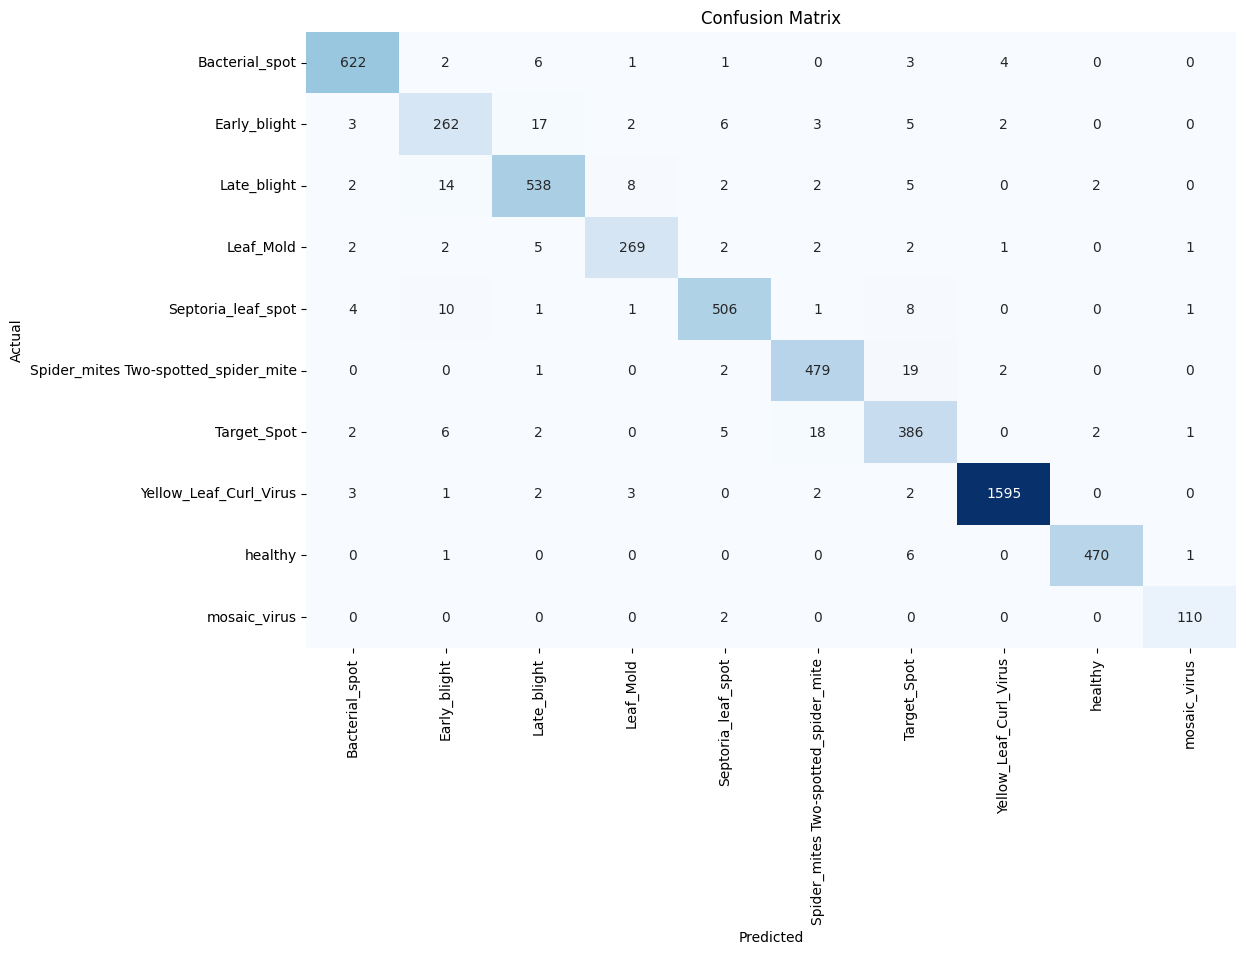

Classification Report:
----------------------
                                       precision    recall  f1-score   support

                      Bacterial_spot     0.9749    0.9734    0.9742       639
                        Early_blight     0.8792    0.8733    0.8763       300
                         Late_blight     0.9406    0.9389    0.9397       573
                           Leaf_Mold     0.9472    0.9406    0.9439       286
                  Septoria_leaf_spot     0.9620    0.9511    0.9565       532
Spider_mites Two-spotted_spider_mite     0.9448    0.9523    0.9485       503
                         Target_Spot     0.8853    0.9147    0.8998       422
              Yellow_Leaf_Curl_Virus     0.9944    0.9919    0.9932      1608
                             healthy     0.9916    0.9833    0.9874       478
                        mosaic_virus     0.9649    0.9821    0.9735       112

                            accuracy                         0.9604      5453
               

In [5]:
acc,f1score,cm,clr=predictor(test_generator,predictions)

# A function that predicts the label from the trained model

In [35]:
#function to predict the tomato leaf Disease 
def predict_class(img) -> str:
    img=cv2.imread(img)
    img= cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    i=np.argmax(model.predict(img))
    p_class=list(train_generator.class_indices.keys())[i]
    p_class= f'{p_class} Disease'
    return p_class
    

In [40]:
#create the gradio UI
gr.Interface(predict_class,
    gr.Image(type="filepath", label="Upload an image of a tomato leaf"),
    outputs=Textbox(label="Disease:"),title="Tomato Leaf Disease Classification",theme='freddyaboulton/dracula_revamped'
    
    
    ).launch(share=False,inline=True,show_api=False)#True for public deployment

Running on local URL:  http://127.0.0.1:7889

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 127ms/step


# TEST SOME PICTURES FROM THE TEST SET

### plots with the actual labels

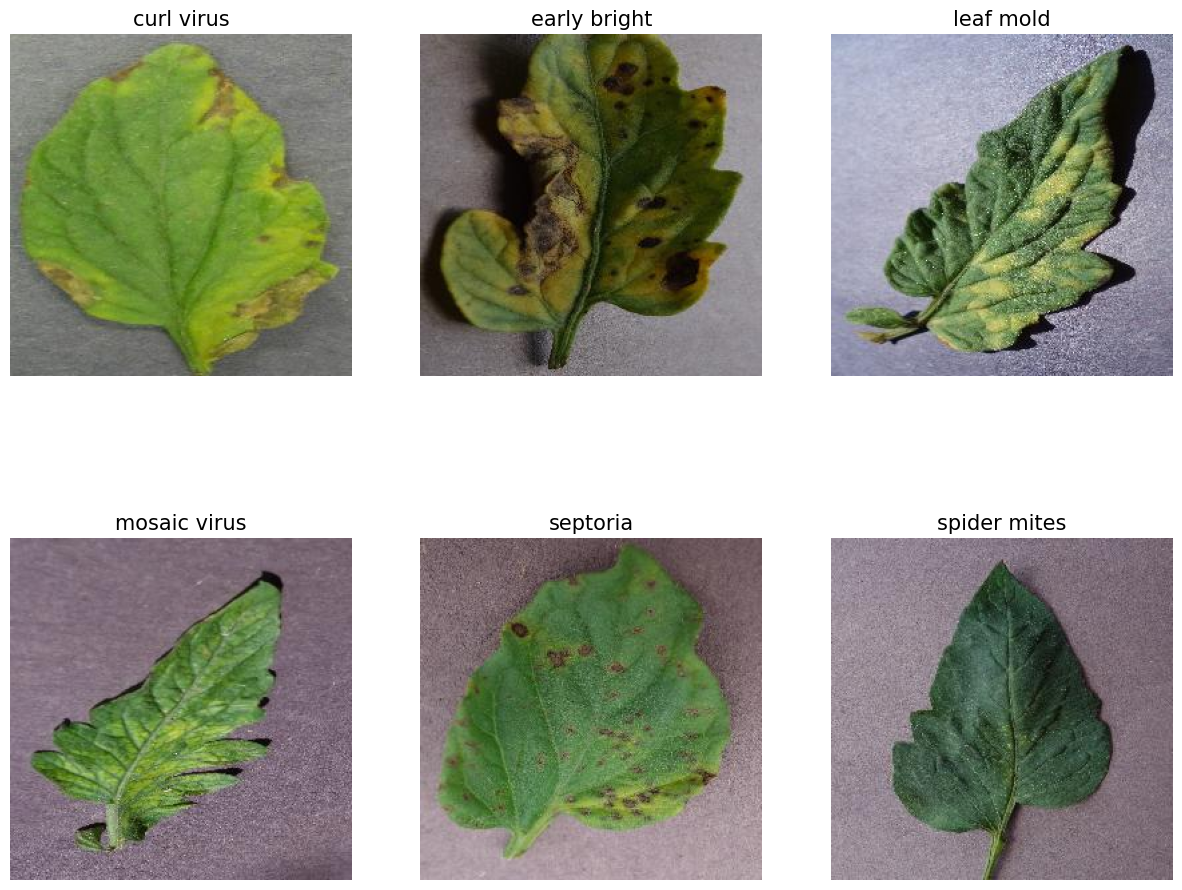

In [6]:
PATH=r'D:\UNI\4th year\SENIOR PROJECT\ABBAS_STUDY\test'
# PATH : "D:\UNI\4th year\SENIOR PROJECT\ABBAS_STUDY\test"

imgs= [(os.path.join(PATH,img)) for img in os.listdir(PATH)]
labels=[(i.split('.JPG'))[0] for i in (os.listdir(PATH))] 

# print(imgs)
imgs_ct = len(imgs)
images=[]
for i in imgs:
    img=cv2.imread(i)
    img= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img)

def plot(rows, col):
    plt.figure(figsize=(15, 12))
    for i in range(imgs_ct):
        plt.subplot(rows, col, i+1)
        plt.imshow(images[i])  
        plt.axis('off')
        plt.title(labels[i],size=15)
    plt.show()

plot(2,3)

## PREDICT THE DISEASES

### PLOTS WITH THE PREDICTED LABELS

1/1 [==============================] - 0s 66ms/step


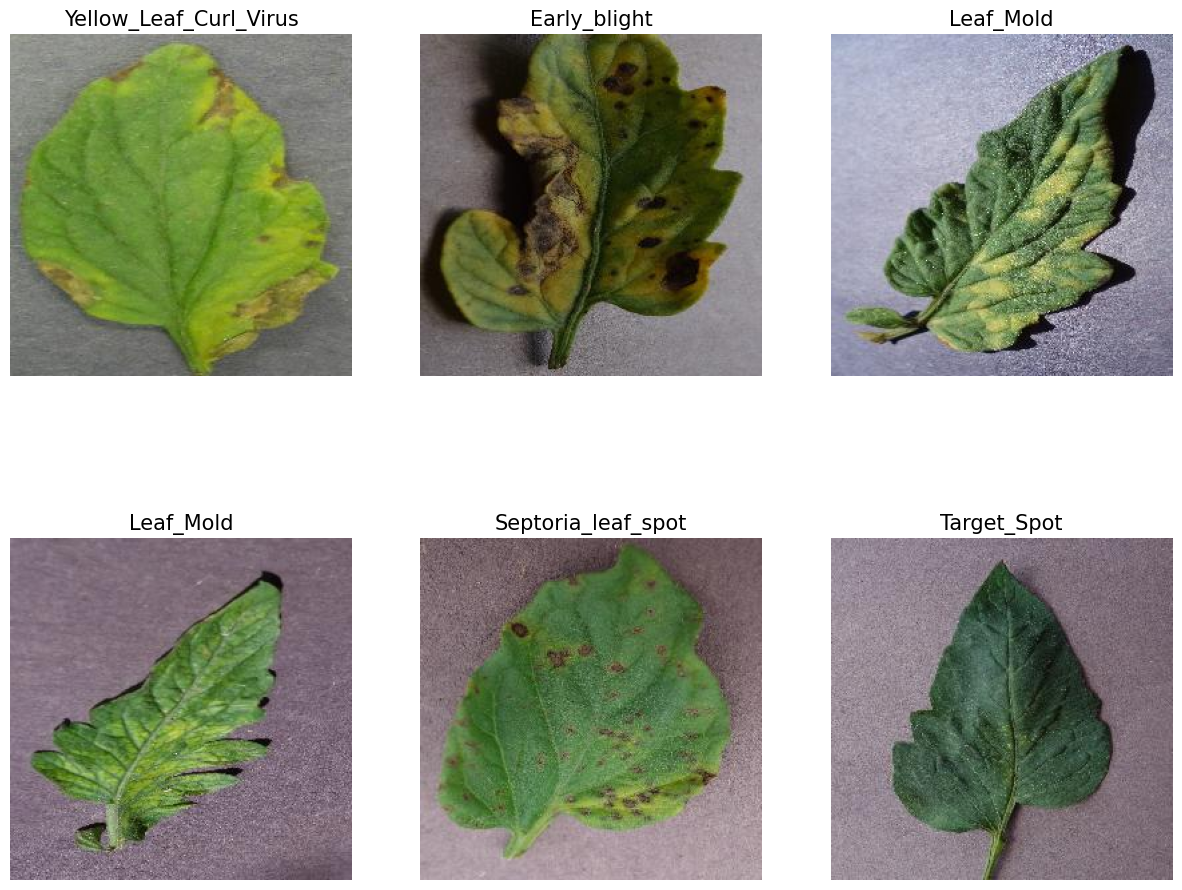

In [9]:
labels=[] # get the labels from the model predictions
for i in imgs:
    label= predict_class(i) # where the model predicts the label
    labels.append(label)

#plot the images with the predicted labels
def plot(rows, col):
    plt.figure(figsize=(15, 12))
    for i in range(imgs_ct):
        plt.subplot(rows, col, i+1)
        plt.imshow(images[i])  
        plt.axis('off')
        plt.title(labels[i],size=15)
    plt.show()

plot(2,3)